In [102]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from scipy.stats import randint, uniform, expon, loguniform
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from typing import Dict
import matplotlib.pyplot as plt

IDs = [
    1075, # datatrieve
    50, # tic-tac-toe
    37, # diabetes
    1068, # pc1
]

import warnings
warnings.filterwarnings('ignore')

In [103]:
datasets = []
for id in IDs:
    dataset_raw = fetch_openml(data_id=id)
    X = dataset_raw.data
    if id == 50:    # only dataset with cathegorical features
        transformer = OneHotEncoder()
    else:
        transformer = StandardScaler()

    X = transformer.fit_transform(X)
    y = dataset_raw.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    dataset = {
        "X_train":X_train,
        "X_test":X_test,
        "y_train":y_train,
        "y_test":y_test,
        "name":dataset_raw["details"]["name"],
    }
    datasets.append(dataset)

In [104]:
models=[
    {
        "name": "RandomForest",
        "class": RandomForestClassifier(),
        "hyperparameter_distribution":{
            "n_estimators": randint(1, 2001),
            "max_samples": uniform(0.1, 0.9),
            "max_features": uniform(0, 1),
            "min_samples_split": loguniform(0.01, 0.2) 
        },
        "hyperparameter_search_spaces":{
            "n_estimators": Integer(1, 2000),
            "max_samples": Real(0.1, 1, "uniform"),
            "max_features": Real(0.01, 1, "uniform"),
            "min_samples_split": Real(0.01, 0.2, "log-uniform")
        },
        "best_params_random": [],
        "best_scores_random": [],
        "results_random": [],
        "best_params_bayes": [],
        "best_scores_bayes": [],
        "results_bayes": [],
    },
    {
        "name": "KNN",
        "class": KNeighborsClassifier(),
        "hyperparameter_distribution":{
            "n_neighbors": randint(1, 31),
            "weights": ["uniform", "distance"]
        },
        "hyperparameter_search_spaces":{
            "n_neighbors": Integer(1, 30),
            "weights": ["uniform", "distance"]
        },
        "best_params_random": [],
        "best_scores_random": [],
        "results_random": [],
        "best_params_bayes": [],
        "best_scores_bayes": [],
        "results_bayes": [],
    },
    {
        "name": "ElasticNet",
        "class": LogisticRegression(penalty="elasticnet", solver="saga"),
        "hyperparameter_distribution":{
            "C": uniform(0.0001, 0.9999),
            "l1_ratio": uniform(0, 1), 
        },
        "hyperparameter_search_spaces":{
            "C": Real(0.0001, 1, "uniform"),
            "l1_ratio": Real(0, 1, "uniform"), 
        },
        "best_params_random": [],
        "best_scores_random": [],
        "results_random": [],
        "best_params_bayes": [],
        "best_scores_bayes": [],
        "results_bayes": [],
    },
]

In [105]:
for model in models:
    for dataset in datasets:
        random_search = RandomizedSearchCV(model["class"], model["hyperparameter_distribution"], random_state=42, n_jobs=-1, n_iter=50, cv=5)
        random_search.fit(dataset["X_train"], dataset["y_train"])
        model["best_params_random"].append(random_search.best_params_)
        model["best_scores_random"].append(random_search.best_score_)
        model["results_random"].append(random_search.cv_results_)

        bayes_search = BayesSearchCV(model["class"], model["hyperparameter_search_spaces"], random_state=42, n_jobs=-1, n_iter=50, cv=5)
        bayes_search.fit(dataset["X_train"], dataset["y_train"])
        model["best_params_bayes"].append(bayes_search.best_params_)
        model["best_scores_bayes"].append(bayes_search.best_score_)
        model["results_bayes"].append(bayes_search._optim_results)

In [106]:
for model in models:
    print(f"model_name: {model['name']} params: {model['best_params_random']}")
    print(f"model_name: {model['name']} params: {model['best_params_bayes']}")

model_name RandomForest params: [{'max_features': 0.18182496720710062, 'max_samples': 0.2650640588680905, 'min_samples_split': 0.024878734419814426, 'n_estimators': 22}, {'max_features': 0.8180147659224931, 'max_samples': 0.8746575249307091, 'min_samples_split': 0.010210451114512973, 'n_estimators': 1480}, {'max_features': 0.5581020020173412, 'max_samples': 0.4634525539522367, 'min_samples_split': 0.012145817744400194, 'n_estimators': 442}, {'max_features': 0.5581020020173412, 'max_samples': 0.4634525539522367, 'min_samples_split': 0.012145817744400194, 'n_estimators': 442}]
model_name RandomForest params: [OrderedDict([('max_features', 0.8142720284737898), ('max_samples', 0.2546844052569046), ('min_samples_split', 0.059989768591227254), ('n_estimators', 1606)]), OrderedDict([('max_features', 0.5829048166111501), ('max_samples', 0.9188332460956758), ('min_samples_split', 0.01), ('n_estimators', 882)]), OrderedDict([('max_features', 0.8077548718477013), ('max_samples', 1.0), ('min_sampl

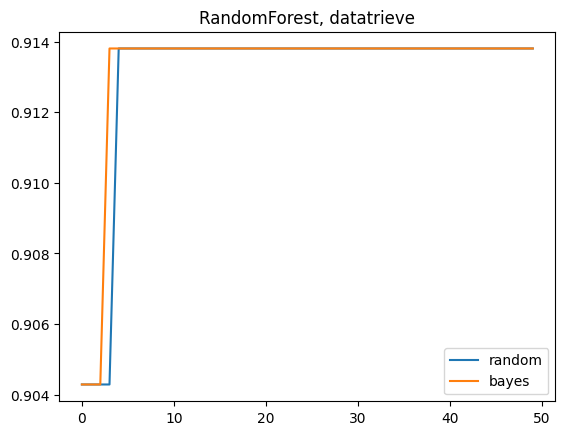

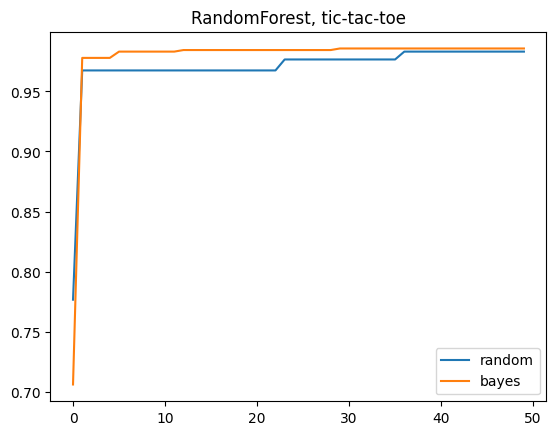

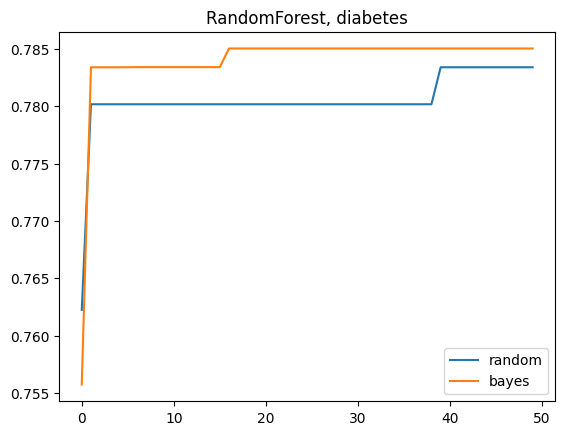

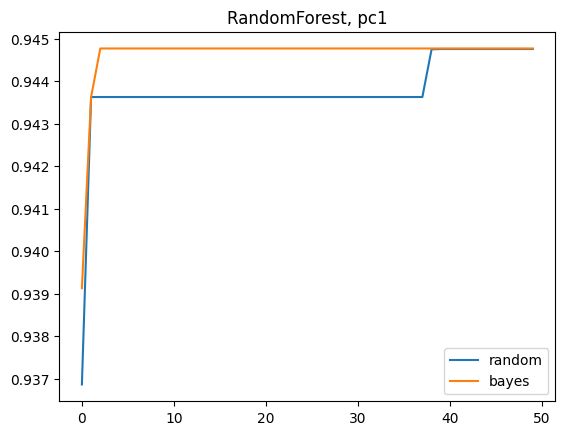

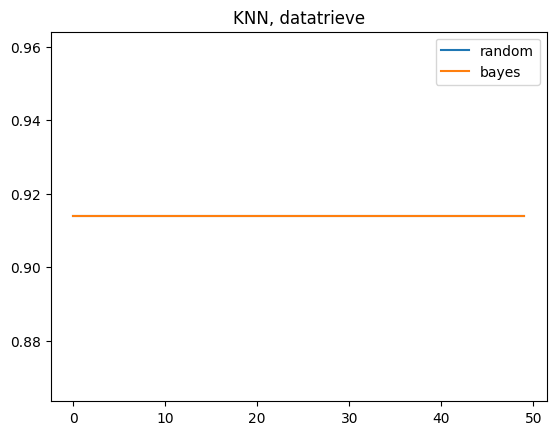

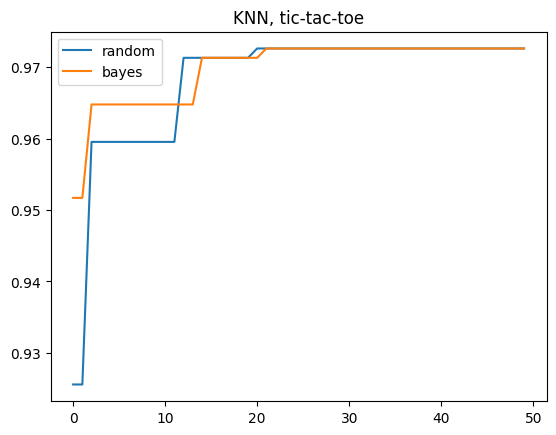

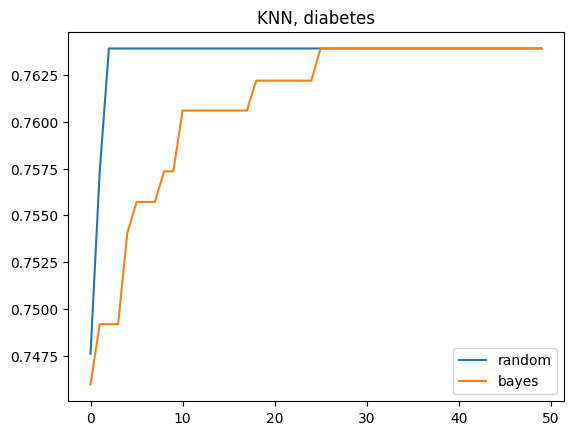

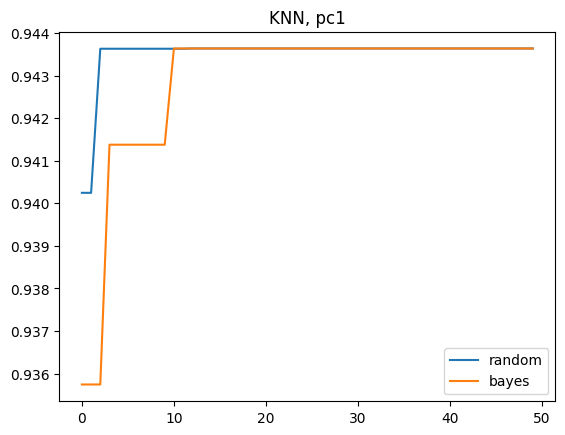

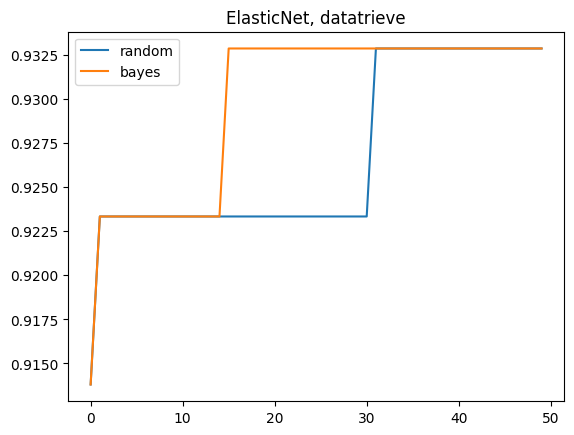

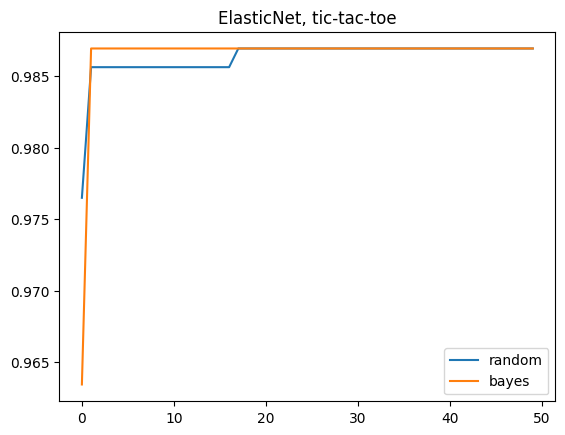

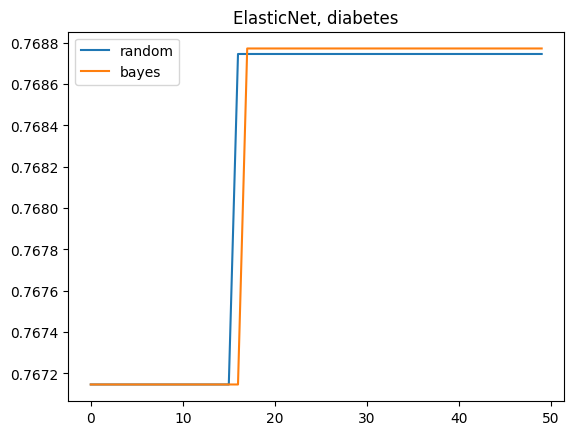

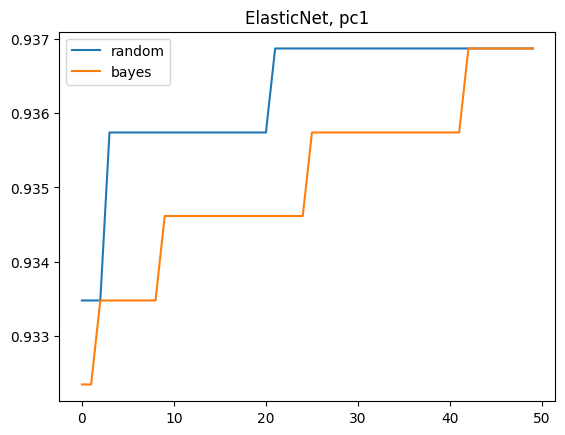

In [127]:
for model in models:
    for i, dataset in enumerate(datasets):
        plt.title(f"{model['name']}, {dataset['name']}")
        plt.plot(np.maximum.accumulate(model["results_random"][i]["mean_test_score"]), label="random")
        plt.plot(np.maximum.accumulate(-model["results_bayes"][i][0]["func_vals"]), label="bayes")
        plt.legend()
        # plt.savefig(f"{model['name']}_{dataset['name']}.png")
        plt.show()

In [111]:
for results in (models[1]["results_random"]):
    print(results["params"])

[{'n_neighbors': 7, 'weights': 'distance'}, {'n_neighbors': 29, 'weights': 'uniform'}, {'n_neighbors': 11, 'weights': 'distance'}, {'n_neighbors': 29, 'weights': 'uniform'}, {'n_neighbors': 7, 'weights': 'distance'}, {'n_neighbors': 19, 'weights': 'uniform'}, {'n_neighbors': 11, 'weights': 'uniform'}, {'n_neighbors': 24, 'weights': 'uniform'}, {'n_neighbors': 4, 'weights': 'distance'}, {'n_neighbors': 24, 'weights': 'uniform'}, {'n_neighbors': 22, 'weights': 'uniform'}, {'n_neighbors': 2, 'weights': 'distance'}, {'n_neighbors': 12, 'weights': 'distance'}, {'n_neighbors': 6, 'weights': 'distance'}, {'n_neighbors': 28, 'weights': 'uniform'}, {'n_neighbors': 1, 'weights': 'distance'}, {'n_neighbors': 26, 'weights': 'distance'}, {'n_neighbors': 29, 'weights': 'distance'}, {'n_neighbors': 25, 'weights': 'uniform'}, {'n_neighbors': 27, 'weights': 'uniform'}, {'n_neighbors': 10, 'weights': 'distance'}, {'n_neighbors': 28, 'weights': 'distance'}, {'n_neighbors': 16, 'weights': 'uniform'}, {'n_

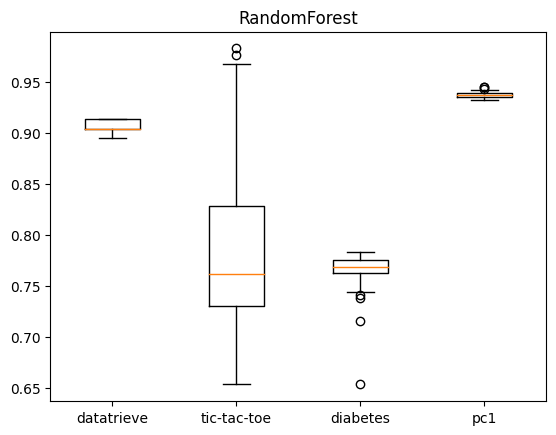

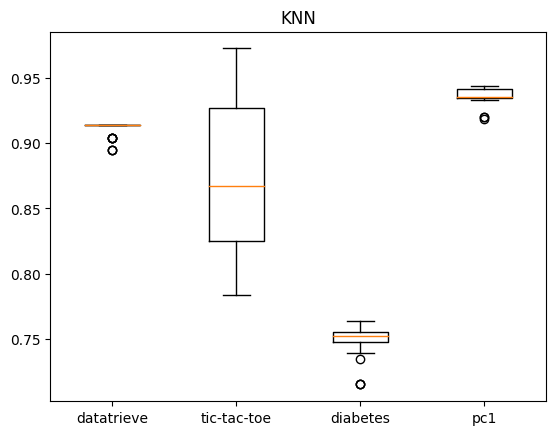

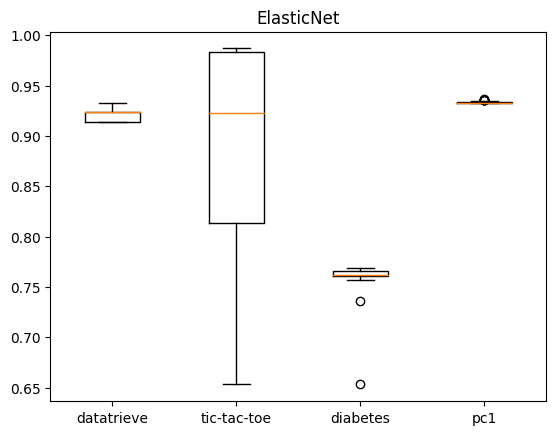

In [112]:
for model in models:
    plt.title(model["name"])
    plt.boxplot([model["results_random"][i]["mean_test_score"] for i in range(4)], labels=[dataset["name"] for dataset in datasets])
    plt.show()

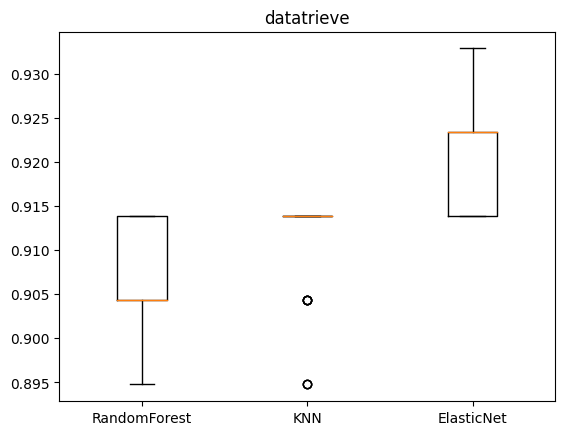

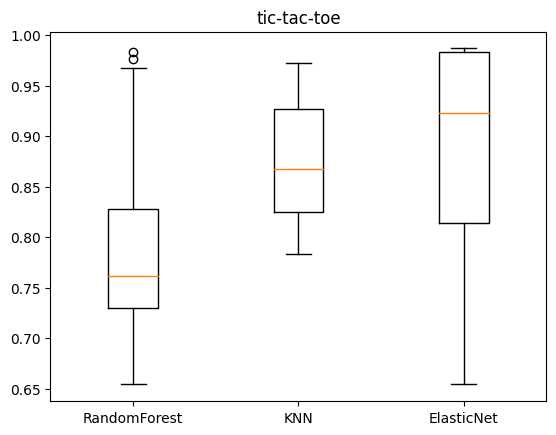

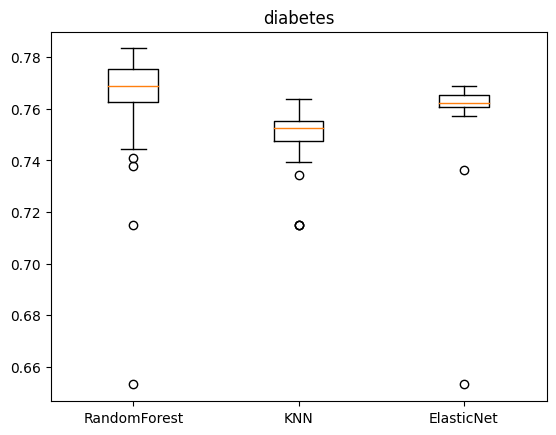

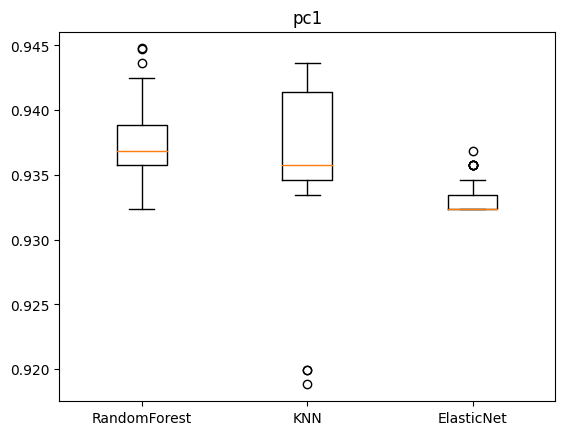

In [129]:
for i, dataset in enumerate(datasets):
    plt.title(dataset["name"])
    plt.boxplot([model["results_random"][i]["mean_test_score"] for model in models], labels=[model["name"] for model in models])
    plt.show()

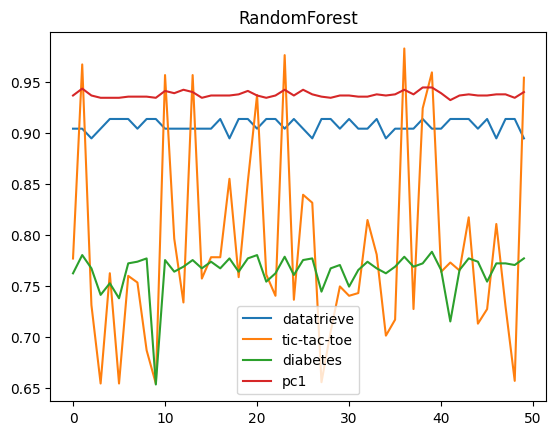

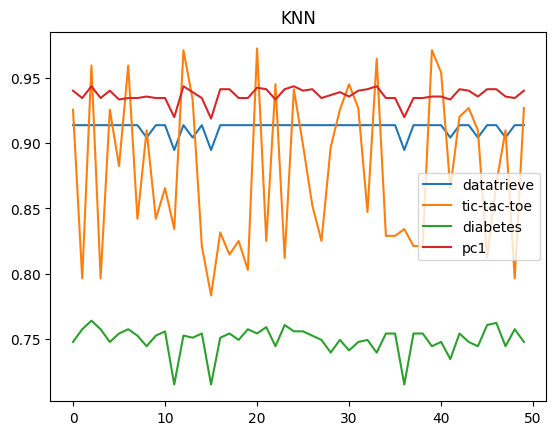

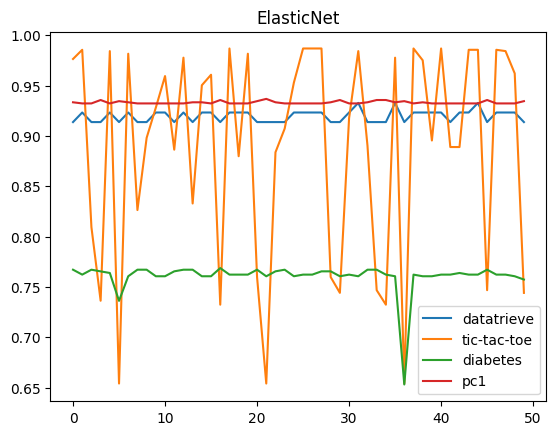

In [113]:
for model in models:
    plt.title(model["name"])
    for i, dataset in enumerate(datasets):
        plt.plot(model["results_random"][i]["mean_test_score"], label=dataset["name"])
    plt.legend()
    plt.show()

In [125]:
for model in models:
    mean_scores = np.stack([model["results_random"][i]["mean_test_score"] for i in range(4)], axis=0).mean(axis=0)
    best_idx = np.argmax(mean_scores)
    best_params = model["results_random"][0]["params"][best_idx]
    for i, dataset in enumerate(datasets):
        best_model = type(model["class"])(**best_params).fit(dataset["X_train"], dataset["y_train"])
        best_test_score = best_model.score(dataset["X_test"], dataset["y_test"])

        specific_model = type(model["class"])(**model["best_params_random"][i]).fit(dataset["X_train"], dataset["y_train"])
        specific_test_score = specific_model.score(dataset["X_test"], dataset["y_test"])


        default_model = type(model["class"])().fit(dataset["X_train"], dataset["y_train"])
        default_test_score = default_model.score(dataset["X_test"], dataset["y_test"])

        print(f"model: {model['name']}, dataset: {dataset['name']}")
        print(f"difference in scores (best - specific): {best_test_score - specific_test_score:.3%}")
        print(f"difference in scores (best - default): {best_test_score - default_test_score:.3%}")

model: RandomForest, dataset: datatrieve
difference in scores (best - specific): 0.000%
difference in scores (best - default): 0.000%
model: RandomForest, dataset: tic-tac-toe
difference in scores (best - specific): 0.000%
difference in scores (best - default): 1.042%
model: RandomForest, dataset: diabetes
difference in scores (best - specific): -3.247%
difference in scores (best - default): 0.649%
model: RandomForest, dataset: pc1
difference in scores (best - specific): 0.450%
difference in scores (best - default): 0.450%
model: KNN, dataset: datatrieve
difference in scores (best - specific): 0.000%
difference in scores (best - default): 3.846%
model: KNN, dataset: tic-tac-toe
difference in scores (best - specific): 0.000%
difference in scores (best - default): 5.729%
model: KNN, dataset: diabetes
difference in scores (best - specific): -0.649%
difference in scores (best - default): -0.649%
model: KNN, dataset: pc1
difference in scores (best - specific): 0.000%
difference in scores (b